In [1]:
import os
from benchmark import VLMBenchmark

# TRY llava:13b

(7 <= parameters <= 30B)

https://huggingface.co/PsiPi/liuhaotian_llava-v1.5-13b-GGUF

In [2]:
benchmark = VLMBenchmark()

In [3]:
test_cases = [
    {
        'name': 'NDA_Extraction',
        'image_path': './convert_docs/Contradictory_NDA_No_Highlight/page_002.png',
        'prompt': 'Extract all clauses from this NDA document. List each clause with its title and main content.',
        'task_description': 'Extract all NDA clauses including titles and content'
    },
    {
        'name': 'Invoice_LineItems',
        'image_path': './convert_docs/FACTURA Nº EI23215925/page_001.png',
        'prompt': 'Extract all line items from this invoice. Include item description, quantity, unit price, and total for each line.',
        'task_description': 'Extract any information you have 100% confidence with from this document'
    }
]

##### Run Benchmark Suit
To get the un-bias result I need to define control (fixed) variables includes:
1. Context size (--ctx-size) = 8192
2. Batch size (--batch-size, --ubatch-size) = 2048, 512
3. CPU threads applied (--threads) = 16
4. Number of generation length (--n-predict) = 512

NOTE:
- we measureed model performance by its response. So it's crucial to set temperature very low (`temp=0`). Additionally, to make results reproducible,
we need to set probability zeed to be constant (`zeed=77`).

1. Baseline:
```
MODEL_PATH="./models/llava-v1.5-13b-f16.gguf"
MMPROJ_PATH="./models/mmproj-model-f16.gguf"

./build/bin/llama-server \
    --model $MODEL_PATH \
    --mmproj $MMPROJ_PATH \
    --alias "llava_baseline" \
    --host 0.0.0.0 \
    --port 10000 \
    --n-gpu-layers 10 \
    --ctx-size 8192 \
    --batch-size 2048 \
    --ubatch-size 512 \
    --threads 16 \
    --n-predict 512 \
    --temp 0 \
    --seed 77 \
    --verbose
```
2. Optimize A:
```
MODEL_PATH="./models/llava-v1.5-13b-f16.gguf"
MMPROJ_PATH="./models/mmproj-model-f16.gguf"

./build/bin/llama-server \
    --model $MODEL_PATH \
    --mmproj $MMPROJ_PATH \
    --alias "llava_optimizeA" \
    --host 0.0.0.0 \
    --port 10000 \
    --n-gpu-layers -1 \ # If you can't go with -1 (maximum GPU offload), you have to find the number manually 
    --ctx-size 8192 \
    --batch-size 2048 \
    --ubatch-size 512 \
    --threads 16 \
    --n-predict 512 \
    --temp 0 \
    --seed 77 \
    --verbose
```
3. Optimize B:
```
MODEL_PATH="./models/llava-v1.5-13b-f16.gguf"
MMPROJ_PATH="./models/mmproj-model-f16.gguf"

./build/bin/llama-server \
    --model $MODEL_PATH \
    --mmproj $MMPROJ_PATH \
    --alias "llava_optimizeB" \
    --host 0.0.0.0 \
    --port 10000 \
    --n-gpu-layers -1 \ # If you can't go with -1 (maximum GPU offload), you have to find the number manually 
    --ctx-size 8192 \
    --batch-size 2048 \
    --ubatch-size 512 \
    --cont-batching \ # adding this
    --threads 16 \
    --n-predict 512 \
    --temp 0 \
    --seed 77 \
    --verbose
```
4. Optimize C:
```
MODEL_PATH="./models/llava-v1.5-13b-f16.gguf"
MMPROJ_PATH="./models/mmproj-model-f16.gguf"

./build/bin/llama-server \
    --model $MODEL_PATH \
    --mmproj $MMPROJ_PATH \
    --alias "llava_optimizeC" \
    --host 0.0.0.0 \
    --port 10000 \
    --n-gpu-layers -1 \ # If you can't go with -1 (maximum GPU offload), you have to find the number manually 
    --ctx-size 8192 \
    --batch-size 2048 \
    --ubatch-size 512 \
    --cont-batching \ # adding this
    --flash-attn \ # adding this
    --threads 16 \
    --n-predict 512 \
    --temp 0 \
    --seed 77 \
    --verbose
```
5. Optimize Y:
```
MODEL_PATH="./models/llava-v1.5-13b-Q8_0.gguf"
MMPROJ_PATH="./models/mmproj-model-Q8_0.gguf"

./build/bin/llama-server \
    --model $MODEL_PATH \
    --mmproj $MMPROJ_PATH \
    --alias "llava_optimizeY" \
    --host 0.0.0.0 \
    --port 10000 \
    --n-gpu-layers -1 \ # If you can't go with -1 (maximum GPU offload), you have to find the number manually 
    --ctx-size 8192 \
    --batch-size 2048 \
    --ubatch-size 512 \
    --cont-batching \
    --flash-attn \
    --threads 16 \
    --n-predict 512 \
    --temp 0 \
    --seed 77 \
    --verbose
```
6. Optimize Z:
```
MODEL_PATH="./models/llava-v1.5-13b-Q5_K_M.gguf"
MMPROJ_PATH="./models/mmproj-model-Q5_0.gguf"

./build/bin/llama-server \
    --model $MODEL_PATH \
    --mmproj $MMPROJ_PATH \
    --alias "llava_optimizeZ" \
    --host 0.0.0.0 \
    --port 10000 \
    --n-gpu-layers -1 \ # If you can't go with -1 (maximum GPU offload), you have to find the number manually 
    --ctx-size 8192 \
    --batch-size 2048 \
    --ubatch-size 512 \
    --cont-batching \
    --flash-attn \
    --threads 16 \
    --n-predict 512 \
    --temp 0 \
    --seed 77 \
    --verbose
```

In [4]:
# llava:13b

model_configs = [
    'Baseline', # NO GPU Offloading (0 gpu layers offloading)
    'Optimize A', # Full GPU Offloading (all gpu layers offloading)
    'Optimize B', # Optimize A + Continuous Batching
    'Optimize C', # Optimize B + Flash Attention
    'Optimize Y', # 8 bit quantization
    'Optimize Z', # 5 bit quantization
]

Running benchmark: NDA_Extraction with Baseline
Running benchmark: Invoice_LineItems with Baseline
Finish running baseline...



Press 'enter' to confirm testing with the next benchmark 


Testing Configuration: Optimize A
Running benchmark: NDA_Extraction with Optimize A

Test: NDA_Extraction
  Latency: 113671.96ms (Baseline: 212165.26ms)
  Token Speed: 4.50 toks/s (Baseline: 2.41 tok/s)
  Throughput: 0.01 imgs/s (Baseline: 0.004713306903848237 imgs/s)
  Accuracy Score: 1.000
  Speedup: 1.87x
Running benchmark: Invoice_LineItems with Optimize A

Test: Invoice_LineItems
  Latency: 3733.41ms (Baseline: 6910.54ms)
  Token Speed: 1.87 toks/s (Baseline: 1.01 tok/s)
  Throughput: 0.27 imgs/s (Baseline: 0.14470657738352577 imgs/s)
  Accuracy Score: 0.000
  Speedup: 1.85x


Press 'enter' to confirm testing with the next benchmark 


Testing Configuration: Optimize B
Running benchmark: NDA_Extraction with Optimize B

Test: NDA_Extraction
  Latency: 114017.25ms (Baseline: 212165.26ms)
  Token Speed: 4.49 toks/s (Baseline: 2.41 tok/s)
  Throughput: 0.01 imgs/s (Baseline: 0.004713306903848237 imgs/s)
  Accuracy Score: 1.000
  Speedup: 1.86x
Running benchmark: Invoice_LineItems with Optimize B

Test: Invoice_LineItems
  Latency: 3762.32ms (Baseline: 6910.54ms)
  Token Speed: 1.86 toks/s (Baseline: 1.01 tok/s)
  Throughput: 0.27 imgs/s (Baseline: 0.14470657738352577 imgs/s)
  Accuracy Score: 0.000
  Speedup: 1.84x


Press 'enter' to confirm testing with the next benchmark 


Testing Configuration: Optimize C
Running benchmark: NDA_Extraction with Optimize C

Test: NDA_Extraction
  Latency: 115477.95ms (Baseline: 212165.26ms)
  Token Speed: 4.43 toks/s (Baseline: 2.41 tok/s)
  Throughput: 0.01 imgs/s (Baseline: 0.004713306903848237 imgs/s)
  Accuracy Score: 0.950
  Speedup: 1.84x
Running benchmark: Invoice_LineItems with Optimize C

Test: Invoice_LineItems
  Latency: 3530.40ms (Baseline: 6910.54ms)
  Token Speed: 1.98 toks/s (Baseline: 1.01 tok/s)
  Throughput: 0.28 imgs/s (Baseline: 0.14470657738352577 imgs/s)
  Accuracy Score: 0.000
  Speedup: 1.96x


Press 'enter' to confirm testing with the next benchmark 


Testing Configuration: Optimize Y
Running benchmark: NDA_Extraction with Optimize Y

Test: NDA_Extraction
  Latency: 37549.85ms (Baseline: 212165.26ms)
  Token Speed: 7.86 toks/s (Baseline: 2.41 tok/s)
  Throughput: 0.03 imgs/s (Baseline: 0.004713306903848237 imgs/s)
  Accuracy Score: 0.500
  Speedup: 5.65x
Running benchmark: Invoice_LineItems with Optimize Y

Test: Invoice_LineItems
  Latency: 12686.25ms (Baseline: 6910.54ms)
  Token Speed: 7.57 toks/s (Baseline: 1.01 tok/s)
  Throughput: 0.08 imgs/s (Baseline: 0.14470657738352577 imgs/s)
  Accuracy Score: 0.500
  Speedup: 0.54x


Press 'enter' to confirm testing with the next benchmark 


Testing Configuration: Optimize Z
Running benchmark: NDA_Extraction with Optimize Z

Test: NDA_Extraction
  Latency: 45537.17ms (Baseline: 212165.26ms)
  Token Speed: 11.24 toks/s (Baseline: 2.41 tok/s)
  Throughput: 0.02 imgs/s (Baseline: 0.004713306903848237 imgs/s)
  Accuracy Score: 0.000
  Speedup: 4.66x
Running benchmark: Invoice_LineItems with Optimize Z

Test: Invoice_LineItems
  Latency: 1784.49ms (Baseline: 6910.54ms)
  Token Speed: 3.92 toks/s (Baseline: 1.01 tok/s)
  Throughput: 0.56 imgs/s (Baseline: 0.14470657738352577 imgs/s)
  Accuracy Score: 0.000
  Speedup: 3.87x


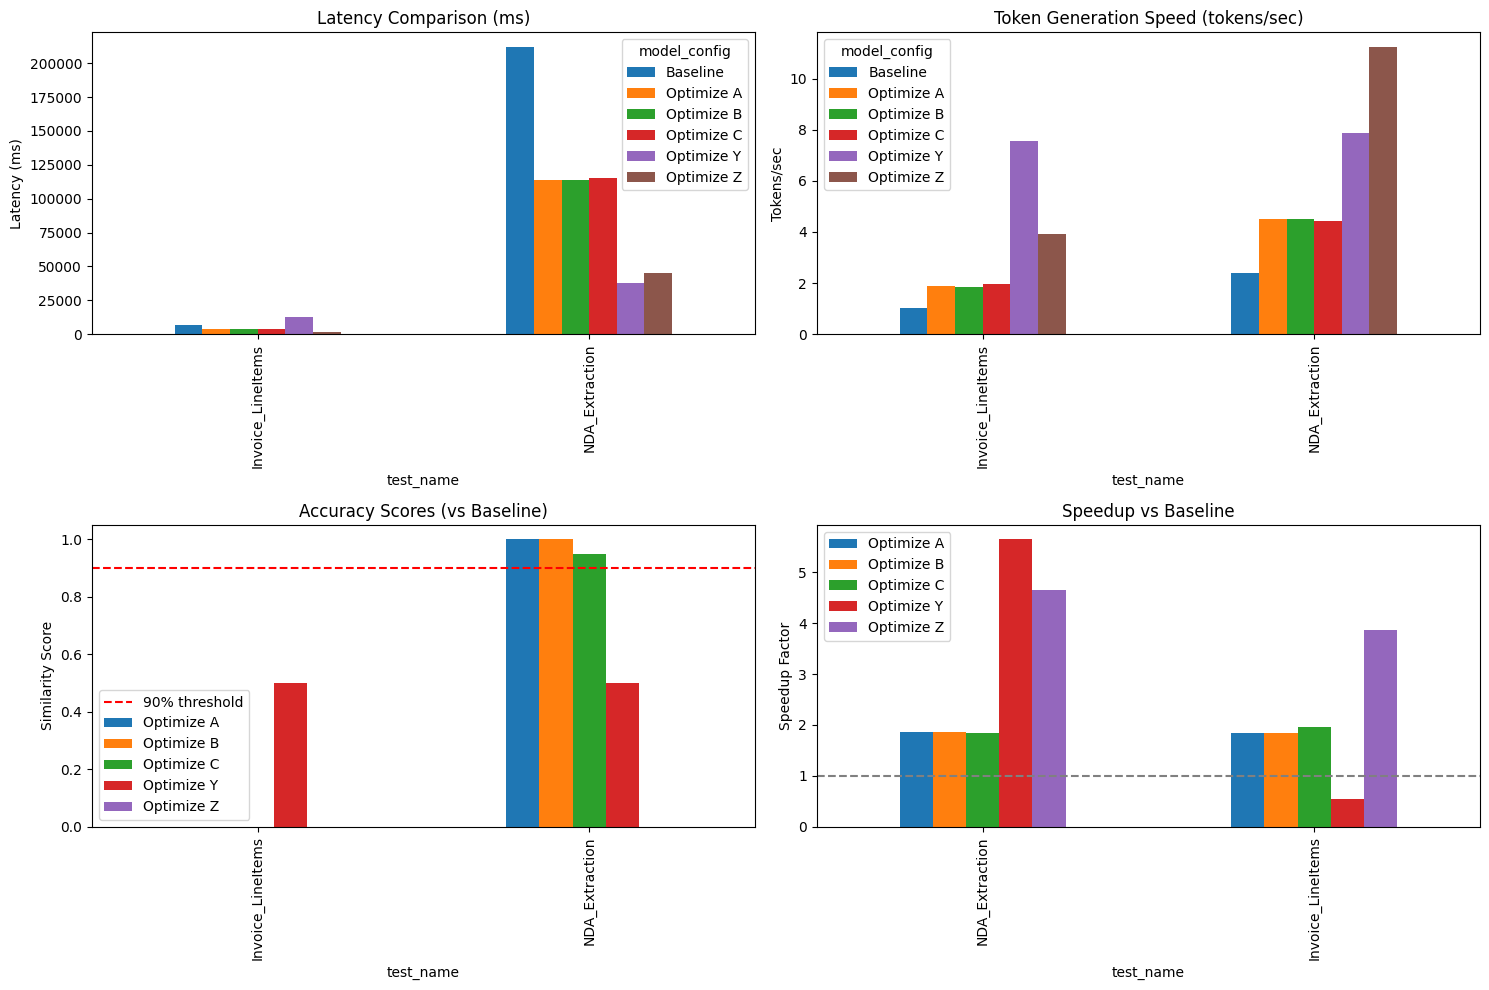


BENCHMARK SUMMARY
    config   avg_latency  avg_token_speed  avg_accuracy  avg_throughput
  Baseline 109537.899578         1.713080         0.000        0.074710
Optimize A  58702.688359         3.189575         0.500        0.138324
Optimize B  58889.783946         3.175552         0.500        0.137282
Optimize C  59504.178769         3.208261         0.475        0.145957
Optimize Y  25118.054354         7.711734         0.500        0.052728
Optimize Z  23660.829676         7.583125         0.000        0.291172


In [5]:
 # Run benchmark suite
results_df = benchmark.benchmark_suite(test_cases, model_configs)

# Generate report
comparison, summary = benchmark.generate_report(results_df)

# TRY Qwen2.5-VL-32B

(> 30B) to prove quantization is worked but with bigger model

https://huggingface.co/Mungert/Qwen2.5-VL-32B-Instruct-GGUF

##### Run Benchmark Suit
To get the un-bias result I need to define control (fixed) variables includes:
1. Context size (--ctx-size) = 8192
2. Batch size (--batch-size, --ubatch-size) = 2048, 512
3. CPU threads applied (--threads) = 16
4. Number of generation length (--n-predict) = 512

NOTE:
- we measureed model performance by its response. So it's crucial to set temperature very low (`temp=0`). Additionally, to make results reproducible,
we need to set probability zeed to be constant (`zeed=77`).


1. QWEN_Baseline:
```
MODEL_PATH="./models/Qwen2.5-VL-32B-Instruct-q4_k_m.gguf"
MMPROJ_PATH="./models/Qwen2.5-VL-32B-Instruct-mmproj-f16.gguf"

./build/bin/llama-server \
    --model $MODEL_PATH \
    --mmproj $MMPROJ_PATH \
    --alias "qwen_optimize_A" \
    --host 0.0.0.0 \
    --port 10000 \
    --n-gpu-layers -1 \ # If you can't go with -1 (maximum GPU offload), you have to find the number manually 
    --ctx-size 8192 \
    --batch-size 2048 \
    --ubatch-size 512 \
    --cont-batching \
    --flash-attn \
    --threads 16 \
    --n-predict 2048 \
    --verbose
```

2. QWEN_Optimize_A:
```
MODEL_PATH="./models/Qwen2.5-VL-32B-Instruct-q3_k_m.gguf"
MMPROJ_PATH="./models/Qwen2.5-VL-32B-Instruct-mmproj-f16.gguf"

./build/bin/llama-server \
    --model $MODEL_PATH \
    --mmproj $MMPROJ_PATH \
    --alias "qwen_optimize_A" \
    --host 0.0.0.0 \
    --port 10000 \
    --n-gpu-layers -1 \ # If you can't go with -1 (maximum GPU offload), you have to find the number manually 
    --ctx-size 8192 \
    --batch-size 2048 \
    --ubatch-size 512 \
    --cont-batching \
    --flash-attn \
    --threads 16 \
    --n-predict 2048 \
    --verbose
```

In [6]:
qwen_benchmark = VLMBenchmark()

In [7]:
qwen_model_configs = [
    'QWEN_Baseline', # GPU Offloading + Continuous Batching + Flash Attention --- Q4_K_M
    'QWEN_Optimize_A', # --- Q3_K_M
]

Running benchmark: NDA_Extraction with QWEN_Baseline
Running benchmark: Invoice_LineItems with QWEN_Baseline
Finish running baseline...



Press 'enter' to confirm testing with the next benchmark 


Testing Configuration: QWEN_Optimize_A
Running benchmark: NDA_Extraction with QWEN_Optimize_A

Test: NDA_Extraction
  Latency: 127996.47ms (Baseline: 135671.43ms)
  Token Speed: 4.17 toks/s (Baseline: 3.42 tok/s)
  Throughput: 0.01 imgs/s (Baseline: 0.007370748440508145 imgs/s)
  Accuracy Score: 0.850
  Speedup: 1.06x
Running benchmark: Invoice_LineItems with QWEN_Optimize_A

Test: Invoice_LineItems
  Latency: 55273.32ms (Baseline: 68899.85ms)
  Token Speed: 4.40 toks/s (Baseline: 3.41 tok/s)
  Throughput: 0.02 imgs/s (Baseline: 0.01451381900112012 imgs/s)
  Accuracy Score: 0.900
  Speedup: 1.25x


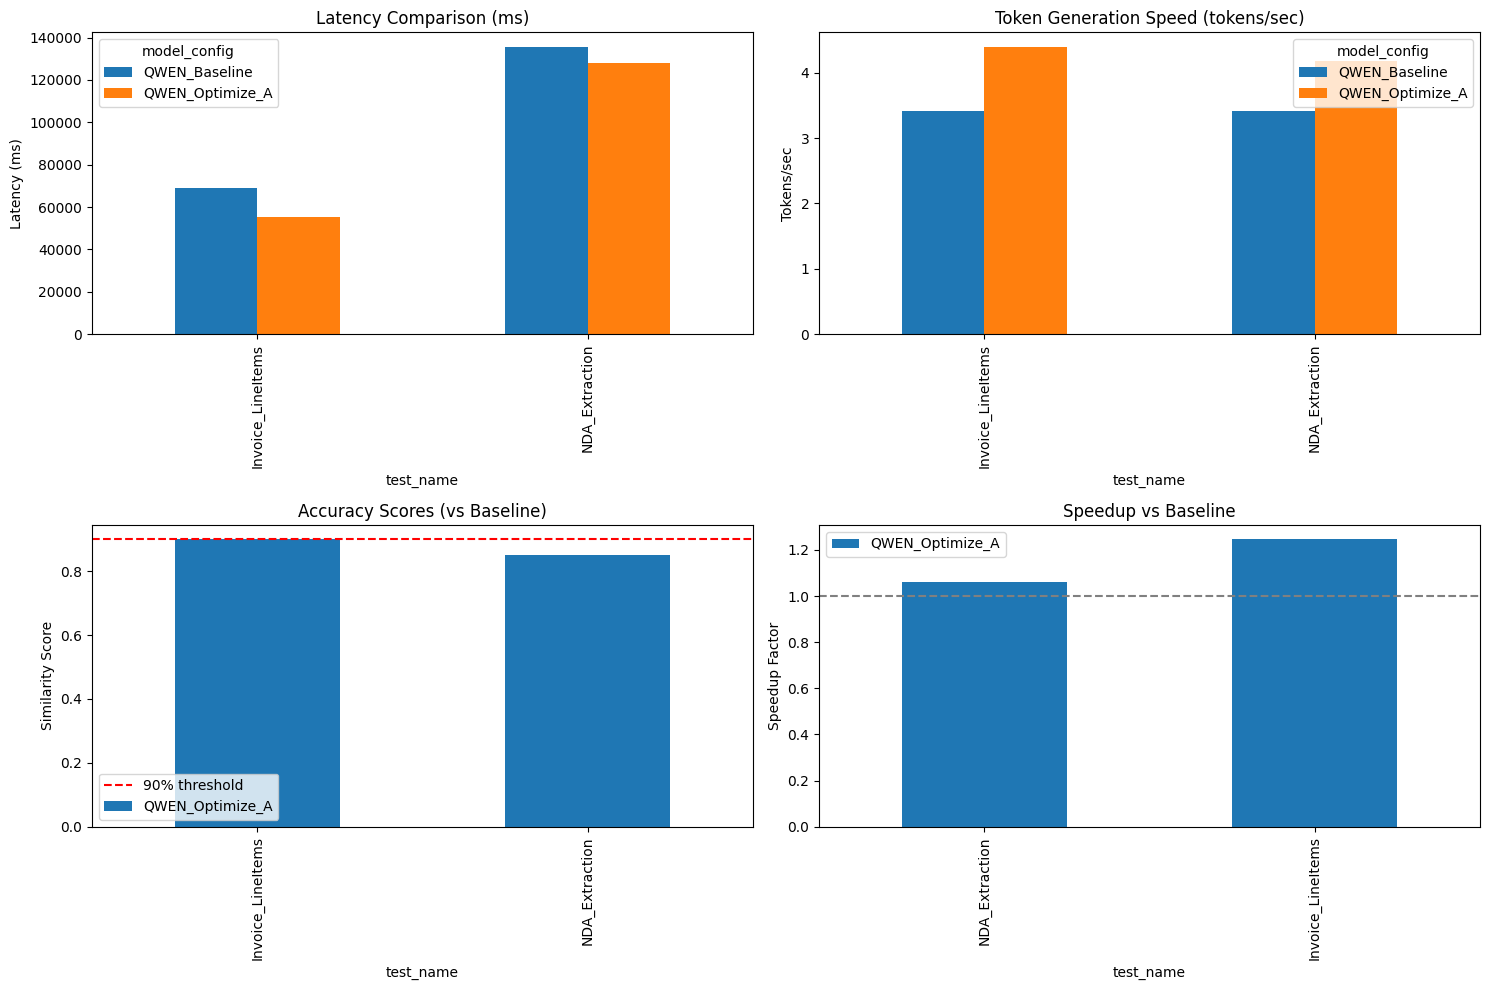


BENCHMARK SUMMARY
         config   avg_latency  avg_token_speed  avg_accuracy  avg_throughput
  QWEN_Baseline 102285.642933         3.415387         0.000        0.010942
QWEN_Optimize_A  91634.893473         4.284162         0.875        0.012952


In [8]:
 # Run Obenchmark suite
qwen_results_df = qwen_benchmark.benchmark_suite(test_cases, qwen_model_configs)

# Generate report
qwen_comparison, qwen_summary = qwen_benchmark.generate_report(qwen_results_df)